# clean data

## import library

In [15]:
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## column index name

In [42]:
DIC_TITLE_INDEX = {"Admin": 0,"bank" : 0, "trade" : 0}
DIC_LINK_INDEX = {"Admin": 1,"bank" : 1, "trade" : 1}
DIC_COMPANY_INDEX = {"Admin": 2,"bank" : 2, "trade" : 2}
DIC_LOCATION_INDEX = {"Admin": 3,"bank" : 3, "trade" : 3}
DIC_POST_DAY_INDEX ={"Admin": 4,"bank" : 5, "trade" : 5}
DIC_CLASSI_INDEX ={"Admin": 5,"bank" : 6, "trade" : 6}

DIC_LOWEST_SALARY_INDEX ={"Admin": 45000,"bank" : 57000, "trade" : 42000}
DIC_HIGHEST_SALARY_INDEX ={"Admin": 75000,"bank" : 85000, "trade" : 120000}

HOUR_SALARY_TO_ANNUAL = 8*200
LOCATION_INDEX = len('location:')
CLASSIFICATION_INDEX = len('classification:')


## read data

In [44]:
def read_data(file_path,job_name):
    """read csv_file with no header, then call each action of function"""
    
    csv_new =pd.read_csv(file_path,header= None)
    csv_new = csv_new.drop(csv_new.index[0]).reset_index()
    csv_new.drop(columns = ['index'],inplace = True)
    csv_new = clean_loc_and_area(csv_new,DIC_LOCATION_INDEX[job_name] )
    csv_new =  clean_salary(csv_new,DIC_CLASSI_INDEX[job_name],job_name)
    csv_new = clean_classification(csv_new,DIC_CLASSI_INDEX[job_name])
    csv_new = post_and_feature(csv_new, DIC_POST_DAY_INDEX[job_name])


    return csv_new

## clean the location and area column

In [49]:
def clean_loc_and_area(csv_new, index = 3):
    
    '''
    The funcation used to clean the location and area column.
    Firstly, get rid of "location: " value.
    And also split the location into two pieces which are area andlocation column.
    Then, fill NA in the area and location column.
    In addition, get rid of salary information in the location column,for example, #eg. abcabc,$23 per hour.
    Finally, call duplicate area function.
    '''
    
    
    csv_new[index] = csv_new[index].apply(lambda x:x[LOCATION_INDEX:])
    csv_new[['area','location']] = csv_new[index].str.split('area: ', expand = True)
    csv_new['location'].fillna('unknown',inplace = True)
    csv_new['area'].fillna('unknown',inplace = True)
    #abcabc,$23 per hour. replace tobcabc
    csv_new['location'] = csv_new['location'].replace('(\,[\s\S]*)',"",regex = True)
    csv_new.drop(columns = [index],inplace = True)
    csv_new['location']= csv_new['location'].apply(dulplicate_loc)
    csv_new['area'] = csv_new['area'].apply(dulplicate_area)
    
    
    return csv_new

## clean the dulplicate value in the location column

In [50]:
def dulplicate_loc(column):
    '''
    clean the dulplicate value in the location column
    '''
    mid = len(column)//2
    if column == 'unknown':
        return 'unknown'
    else:
        return column[mid:]

## clean the dulplicate value in the area column

In [51]:
def dulplicate_area(column):
    '''
    clean the dulplicate value in the area column
    '''
    mid = len(column)//2
    if column == 'unknown':
        return 'unknown'
    else:
        return column[mid+1:]

## clean the salary column

In [68]:
def clean_salary(csv_new,index,job_name):
    '''
    The funcation is used to clean salary column and modify low_salary and high_salary column.
    First, find salary information in the classification column by using salary funcation.
    Then extract salary column that has number value inside, then put the value that has 'to' change to '-',
    ',' change to ''and the number value has '%', put it change to ''. For example, $15 to $25 change to $15-$25. 
    25,000 change to 25000. '8% holiday pay' change to ''( because we consider about the salary, so we ignore holiday pay)
    
    In addition, we fill na value to unknown in the salary column.
    
    Then, clean the salary column,split salary collumn into two pieces that are called high salary.
    and low salary.
    
    In addition, extract number that what we want in the low_salary and high_salary column.
    
    And also extract the number we want in the low salary and high salary column. put the value has ' ' change to '',
    the value has 'k' change to '000' and put value has "$" change to ''.
    For example,70 000 change to 70000. 25k change to 25000.$14 change to 14.
    
    If the low _salary is unknown, high_salary has a number, then put number also in the low_salary column.
    If the high_salary is unknown, low_salary has a number, then put number also in the high_salary column.
    
    Random select number from the salary range.These range are search on the website in the low_salary and high_salary
    column.
    Next, transfer low_salary and high_salary type.
    Fianlly, Count salary for a year in the low salary and high salary column.
   
    '''
    
    csv_new['salary']= csv_new[index].apply(salary)
    
    csv_new['salary'] = csv_new[csv_new['salary'].str.contains('\d', na= False)]['salary'].str.replace('to','-',regex = True)
    csv_new['salary'] = csv_new[csv_new['salary'].str.contains('\d',na = False)]['salary'].str.replace(',','',regex = True)
    csv_new['salary'] = csv_new[csv_new['salary'].str.contains('\d',na = False)]['salary'].str.replace('\d\%','',regex = True)
    

    csv_new['salary'] = csv_new['salary'].fillna('unknown')
    
    # n = 1 means only split one time according to '-'.
    csv_new[['low_salary','high_salary']] = csv_new['salary'].str.split('-',n = 1, expand = True)
    csv_new[['low_salary','high_salary']]=csv_new[['low_salary','high_salary']].fillna('unknown')
    
    csv_new['low_salary'] = csv_new['low_salary'].str.extract(r'(\d+\.\d+|\d+ \d+|\d+k|\d+)',expand = False)
    csv_new['high_salary'] = csv_new['high_salary'].str.extract(r'(\d+\.\d+|\d+ \d+|\d+k|\d+)',expand = False) 
    
    csv_new['low_salary'] = csv_new[csv_new['low_salary'].str.contains('\d',na= False)]['low_salary'].str.replace(' ','',regex = True)
    csv_new['high_salary'] = csv_new[csv_new['high_salary'].str.contains('\d',na= False)]['high_salary'].str.replace(' ','',regex = True)
    
    csv_new['low_salary'] = csv_new[csv_new['low_salary'].str.contains('\d',na = False)]['low_salary'].str.replace('k','000',regex = True)
    csv_new['high_salary'] = csv_new[csv_new['high_salary'].str.contains('\d',na = False)]['high_salary'].str.replace('k','000',regex = True)
    
    csv_new['low_salary'] = csv_new[csv_new['low_salary'].str.contains('\d',na = False)]['low_salary'].str.replace('$','',regex = True)
    csv_new['high_salary'] = csv_new[csv_new['high_salary'].str.contains('\d',na = False)]['high_salary'].str.replace('$','',regex = True)
    
   
      
    csv_new['low_salary'] = csv_new['low_salary'].fillna('unknown')
    csv_new['high_salary'] = csv_new['high_salary'].fillna('unknown')
    
    csv_new.loc[csv_new['low_salary']=='unknown','low_salary'] = csv_new['high_salary']
    csv_new.loc[csv_new['high_salary']=='unknown','high_salary'] = csv_new['low_salary']
       
    # Random select number from salary range that search on the website for the low_salary column.
    #For example, $45000 and $75000 is the salary range for the administrative field.
    for index1, row in enumerate(csv_new['low_salary'].values):
        if row == "unknown":
            csv_new['low_salary'][index1] = np.random.randint(DIC_LOWEST_SALARY_INDEX[job_name], DIC_HIGHEST_SALARY_INDEX[job_name],size = 1 )[0]
           
    # Random select number from salary range that search on the website for the high salary column.
    for index1, row in enumerate(csv_new['high_salary'].values):
        if row == "unknown":
            # that makes high_salary's value is always equal or higher than low_salary's value.
            csv_new['high_salary'][index1] = max(np.random.randint(DIC_LOWEST_SALARY_INDEX[job_name], DIC_HIGHEST_SALARY_INDEX[job_name],size = 1 )[0],csv_new['low_salary'][index1])
            
    csv_new['low_salary'] = csv_new['low_salary'].astype('float32')
    csv_new['high_salary'] = csv_new['high_salary'].astype('float32') 
    
    # if low_salary or high_salary's value always lower than 50, then we will modify low_salary and high_salary put the hour salary change to annual.
    csv_new.loc[csv_new['low_salary'] < 50, 'low_salary'] = csv_new['low_salary'] * HOUR_SALARY_TO_ANNUAL
    csv_new.loc[csv_new['high_salary'] < 50, 'high_salary'] = csv_new['high_salary'] * HOUR_SALARY_TO_ANNUAL
    
            
    return csv_new

## find salary value in the classification column

In [69]:
def salary(column):
    '''
    find salary value in the classification column
    '''
    if "classification" in column:
        return 'unknown'
    else:
        return column

## clean the classification column

In [70]:
def clean_classification(csv_new, index):
    '''
    The function is used to clean the classification column.
    Firstly, we use the classi funcation, to get rid of the column has salary information.
    Then, we fill NA value to unknown in the classification column. 
    Next, we split the collumn by 'subclassification: ' into two pieces that are 'classification_change'
    and 'classification'column.
    We call the duplicate_classi funcation to clean the dulplicate value in the classification column
    Then, get rid of 'classificaiton:' in the classification column.And split the classification_change into 3 pieces.
    Drop the original one.
    Finally, fill NA value in the classification1, classification2, classification3 and company column
    '''
    
    
    csv_new['classification']=csv_new[index].apply(classifi)
    
    csv_new['classification'] = csv_new['classification'].fillna('unknown')
    
    csv_new[['classification_change','classification']] = csv_new['classification'].str.split('subClassification: ',expand =True)
    
    csv_new['classification']=csv_new['classification'].fillna('unknown')
    csv_new['classification'] = csv_new['classification'].apply(dulplicate_classi)
    csv_new['classification_change'] = csv_new['classification_change'].apply(lambda x:x[CLASSIFICATION_INDEX:])
    csv_new[['classification1','classification2','classification3']] = csv_new['classification_change'].str.split(' & ',expand = True)
    csv_new.drop(columns = ['classification_change',index], inplace = True)
    
    csv_new['classification1']= csv_new['classification1'].fillna('unknown')
    csv_new['classification1'] = csv_new['classification1'].apply(classification)
    csv_new['classification2']= csv_new['classification2'].fillna('unknown')
    csv_new['classification2'] = csv_new['classification2'].apply(classification)
    csv_new['classification3']= csv_new['classification3'].fillna('unknown')
    csv_new['classification3'] = csv_new['classification3'].apply(classification)
    
   
  
    
    
    
    return csv_new
    
    

In [71]:
def classification(a):
    '''
    Get rid of '' in the classification1, classification2, classification3 column.
    '''
    if a == '':
        return 'unknown'
    else:
        return a 

## clean the classification column

In [72]:
# clean out $23- $25 per hour
def classifi(a):
    '''
    clean salary information in the classification column.
    '''
    if "classification" not in a :
        return None
    else:
        return a 

## clean the dulplicate value in the classification collumn

In [73]:
def dulplicate_classi(a):
    '''
    clean the dulplicate value in the classification column
    '''
    mid = len(a)//2
    if a == 'unknown':
        return 'unknown'
    else:
        return a[mid:]

## clean the post_time and feature column

In [74]:

def post_and_feature(csv_new, index):
    
    '''
    split the post time column into two pieces that are 'post_time' and 'feature_at' column.
    fill NA value in the post_time and feature_at column
    extract day post time in the post_time column,for example, 21d ago change to 21d
    transfer the post_time to string.
    Finally ,use the post_time funcation to extract number in the post_time column,
    and drop the original column
    '''
    csv_new[['post_time','feature_at']] = csv_new[index].str.split(',at,', expand = True)
    
    csv_new['post_time']= csv_new['post_time'].fillna('unknown')
    csv_new['feature_at'] = csv_new['feature_at'].fillna('unknown')
    
    csv_new['post_time']= csv_new['post_time'].str.extract('(\d+[a-z]+)',expand = False)
    
    csv_new['post_time'] = csv_new['post_time'].astype('str')
    csv_new['post_time'] = csv_new['post_time'].apply(post_time)
    
    csv_new.drop(columns = [index],inplace = True)
    return csv_new


## extract number in the post_time column

In [75]:
def post_time(a):
    '''
    extract time number posted based on day.
    '''
    if 'd' in a:
        find1 = int(a.index('d'))
        return -int(a[:find1])
    elif "m" in a:
        find2 = a.index('m')
        final = -int(a[:find2]) *30
        return final 
    else:
        return 0


In [76]:
admin_df = read_data('/Users/wangzhuoxin/Desktop/project_resource/NZ_Admin_JOBS.csv',"Admin")
admin_df.head(1000)


,0,1,2,area,location,salary,low_salary,high_salary,classification,classification1,classification2,classification3,post_time,feature_at
0,Administrator,https://www.seek.co.nz/job/50582301?type=promo...,NaN,Bay of Plenty,Tauranga,unknown,68766.0,68766.0,Office Management,Administration,Office SupportAdministration,Office Support,0,Private Advertiser
1,Receptionist,https://www.seek.co.nz/job/50620889?type=promo...,Avenues Orthodontics,Bay of Plenty,Tauranga,unknown,61711.0,61711.0,Receptionists,Administration,Office SupportAdministration,Office Support,0,unknown
2,Prosecutions Support Officer,https://www.seek.co.nz/job/50622169?type=stand...,New Zealand Police,Auckland,unknown,unknown,65234.0,73518.0,Other,Administration,Office SupportAdministration,Office Support,-4,unknown
3,Early Childhood Centre Administrator,https://www.seek.co.nz/job/50639620?type=stand...,Kew Pacific Island Early Learning Centre,Southland,Invercargill,unknown,61572.0,72470.0,Administrative Assistants,Administration,Office SupportAdministration,Office Support,0,unknown
4,Business Support Administrator,https://www.seek.co.nz/job/50622432?type=stand...,NaN,Canterbury,Christchurch,unknown,54607.0,59002.0,Client & Sales Administration,Administration,Office SupportAdministration,Office Support,-4,Private Advertiser
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Business Professional - Temporary Opportunities,https://www.seek.co.nz/job/50482020?type=stand...,Enterprise Recruitment,Canterbury,Christchurch,unknown,66963.0,66963.0,Office Management,Administration,Office SupportAdministration,Office Support,-28,unknown
996,Seeking Executive Support Candidates,https://www.seek.co.nz/job/50504568?type=stand...,GBL Personnel,Wellington,unknown,unknown,61644.0,61644.0,Administrative Assistants,Administration,Office SupportAdministration,Office Support,-25,unknown
997,PA / Team Administrators,https://www.seek.co.nz/job/50494221?type=stand...,Beyond Recruitment - Winner – Best Innovation ...,Wellington,unknown,unknown,66608.0,66608.0,"PA, EA & Secretarial",Administration,Office SupportAdministration,Office Support,-26,unknown
998,Temporary Service Coordinator,https://www.seek.co.nz/job/50518469?type=stand...,Graham Consulting,Auckland,Auckland Central,unknown,49089.0,54706.0,Administrative Assistants,Administration,Office SupportAdministration,Office Support,-21,unknown


In [77]:
trade_df = read_data('/Users/wangzhuoxin/Desktop/project_resource/NZ_TRADE_SERVICES_JOBS.csv',"trade")
trade_df.head()

,0,1,2,4,area,location,salary,low_salary,high_salary,classification,classification1,classification2,classification3,post_time,feature_at
0,Cabinet Maker - Kitchens,https://www.seek.co.nz/job/50581799?type=promo...,Kitchen Link (2015) Ltd,classification: Trades & ServicesTrades & Serv...,Auckland,Rodney & North Shore,unknown,60803.0,61907.0,Carpentry & Cabinet Making,Trades,ServicesTrades,Services,0,unknown
1,Retaining Wall Skilled Operator/Builder,https://www.seek.co.nz/job/50610755?type=promo...,Hamilton Fencing Ltd,classification: Trades & ServicesTrades & Serv...,Waikato,Hamilton,$27.50 - $40.00 per hourPlus Time and a half,44000.0,64000.0,unknown,unknown,unknown,unknown,0,unknown
2,Trainee Locksmith,https://www.seek.co.nz/job/50590717?type=stand...,EQUIP Recruitment Ltd,classification: Trades & ServicesTrades & Serv...,Wellington,Hutt Valley,unknown,83298.0,83298.0,Locksmiths,Trades,ServicesTrades,Services,-5,unknown
3,Labourer,https://www.seek.co.nz/job/50606442?type=stand...,AB Contracting Ltd,classification: Trades & ServicesTrades & Serv...,Canterbury,Christchurch,unknown,117061.0,117061.0,Labourers,Trades,ServicesTrades,Services,-1,unknown
4,Sawmill Labourers,https://www.seek.co.nz/job/50608729?type=stand...,Superior Personnel Ltd,classification: Trades & ServicesTrades & Serv...,Canterbury,North Canterbury,unknown,71853.0,71853.0,Labourers,Trades,ServicesTrades,Services,0,unknown


In [78]:
bank_df = read_data('/Users/wangzhuoxin/Desktop/project_resource/NZ_Banking_JOBS.csv',"bank")
bank_df.head()

,0,1,2,4,area,location,salary,low_salary,high_salary,classification,classification1,classification2,classification3,post_time,feature_at
0,Accounts Receivable,https://www.seek.co.nz/job/50568753?type=promo...,at MTF Finance Mt Wellington,classification: Banking & Financial ServicesBa...,Auckland,Auckland Central,unknown,81339.0,81339.0,Credit,Banking,Financial ServicesBanking,Financial Services,0,unknown
1,Internal Audit Manager,https://www.seek.co.nz/job/50556333?type=promo...,at Industrial and Commercial Bank of China (Ne...,classification: Banking & Financial ServicesBa...,Auckland,Auckland Central,unknown,63109.0,70713.0,Compliance & Risk,Banking,Financial ServicesBanking,Financial Services,0,unknown
2,Client Services Officer,https://www.seek.co.nz/job/50638706?type=stand...,at NZ Funds Management Limited,classification: Banking & Financial ServicesBa...,Auckland,Auckland Central,unknown,80187.0,80187.0,Client Services,Banking,Financial ServicesBanking,Financial Services,0,unknown
3,Customer Banking Consultant - Invercargill,https://www.seek.co.nz/job/50637958?type=stand...,at Westpac,classification: Banking & Financial ServicesBa...,Southland,Invercargill,unknown,68834.0,68834.0,unknown,unknown,unknown,unknown,-1,unknown
4,Private Wealth Assistant - Queenstown,https://www.seek.co.nz/job/50617226?type=stand...,at Craigs Investment Partners,classification: Banking & Financial ServicesBa...,Otago,Queenstown & Wanaka,unknown,83730.0,83730.0,Client Services,Banking,Financial ServicesBanking,Financial Services,-5,unknown


# Q: What is the largest market size in different locations for administrative, trade and bank field?
 

## Answers:

Firstly, we create new dataframe for administrative, trade and bank field.These dataframes are group by location and count it based on the location column, then reset_index.
In addition, we sort values by using count column by using descending order for each field.
Secondly, we create 1 row x 3 columns axes with no data and modify the figure size, put these different field dataframe into different subplot, then draw the bar chart in each subplot by using matplotlib method.
Finally, set labels for each field.

From the graph, we can see that Auckland Central is the largest market size in different location in different field.


/Users/wangzhuoxin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/wangzhuoxin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/wangzhuoxin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator


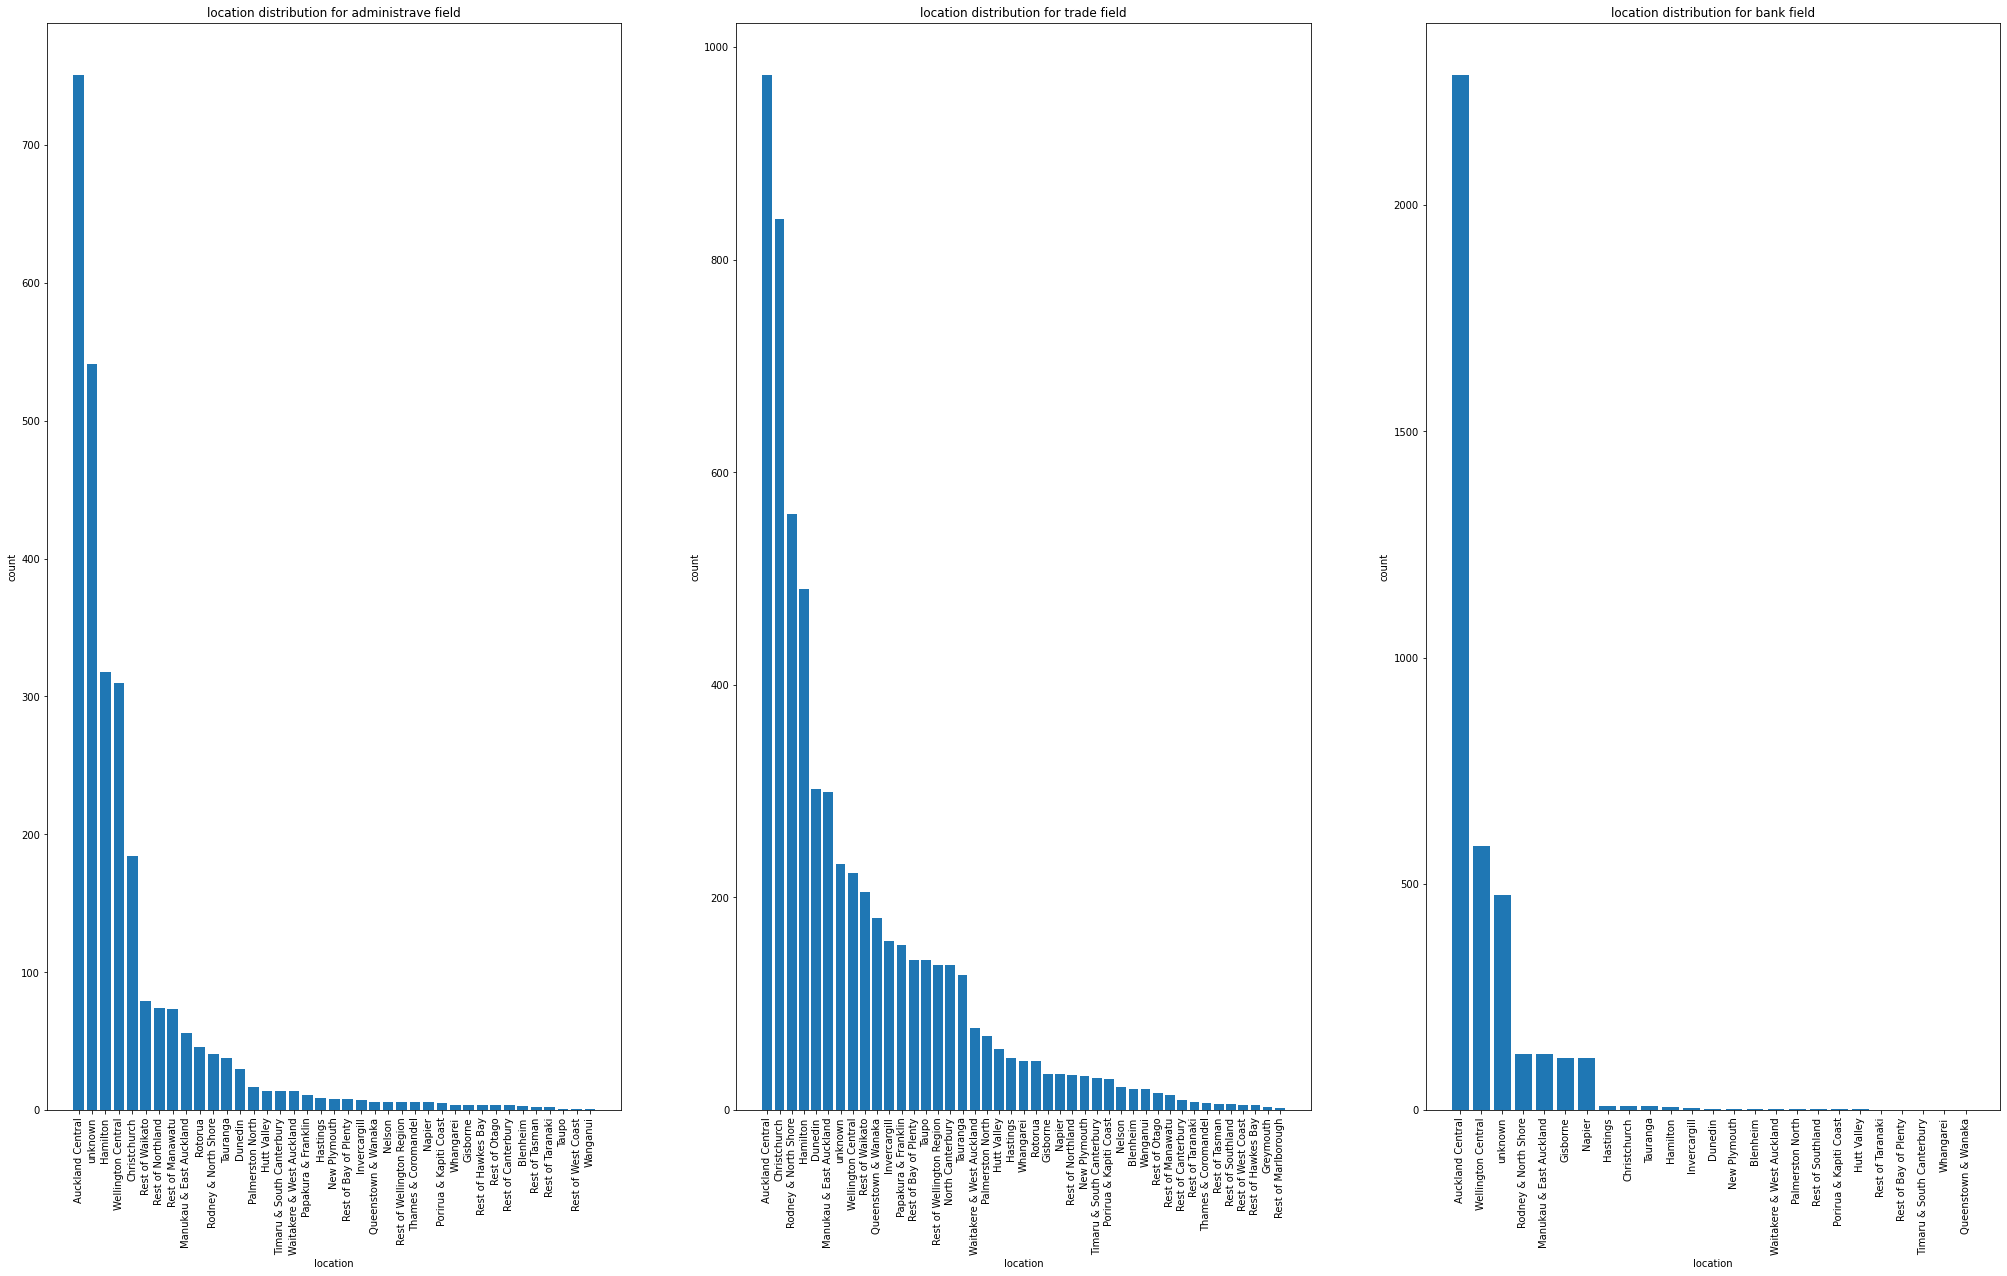

In [79]:
#location distribution for administrative area

#create admin_loc_df
admin_df['count'] = 1
#create admin_loc_df which group by location column,then sum the count based on the location column.Finally,reset_index.
admin_loc_df = admin_df[['location','count']].groupby(admin_df['location']).sum().reset_index()
# sort values based on count by using decending order.
admin_loc_df = admin_loc_df.sort_values(by=['count'],ascending=False)



#matplotlib
# draw the bar plot for adminitrative field in the first subplot.
# creat the subplot
fig,ax  = plt.subplots(1,3,squeeze = False,figsize = (35,20))
# range the xlabel's ratation to 90 degree
ax[0][0].set_xticklabels(admin_loc_df['location'],rotation = 90)
# create bar plot
ax[0][0].bar(admin_loc_df['location'],admin_loc_df['count'])
# set x label, y label and title information
ax[0][0].set_xlabel('location')
ax[0][0].set_ylabel('count')
ax[0][0].set_title('location distribution for administrave field')




#create trade_loc_df
trade_df['count'] = 1
#create trade_loc_df which group by location column,then sum the count based on the location column.Finally,reset_index.
trade_loc_df = trade_df[['location','count']].groupby(trade_df['location']).sum().reset_index()
# sort values based on count by using decending order.
trade_loc_df = trade_loc_df.sort_values(by=['count'],ascending=False)


# draw the bar plot for trade field in the second subplot.
ax[0][1].set_xticklabels(trade_loc_df['location'],rotation = 90)
# create bar plot
ax[0][1].bar(trade_loc_df['location'],trade_loc_df['count'])
# set x label, y label and title information
ax[0][1].set_xlabel('location')
ax[0][1].set_ylabel('count')
ax[0][1].set_title('location distribution for trade field')



#create bank_loc_df
bank_df['count'] = 1
#create admin_loc_df which group by location column,then sum the count based on the location column.Finally,reset_index.
bank_loc_df = bank_df[['location','count']].groupby(bank_df['location']).sum().reset_index()
# sort values based on count by using decending order.
bank_loc_df = bank_loc_df.sort_values(by=['count'],ascending=False)


# draw the bar plot for bank field in the third subplot.
ax[0][2].set_xticklabels(bank_loc_df['location'],rotation = 90)
# create bar plot
ax[0][2].bar(bank_loc_df['location'],bank_loc_df['count'])
# set x label, y label and title information
ax[0][2].set_xlabel('location')
ax[0][2].set_ylabel('count')
ax[0][2].set_title('location distribution for bank field')



plt.show()


# Q : What is the most popular classification shares in the market for different field?

## Answers: 

Firstly, we create 3 row x 1 columns axes with no data and modify the figure size, then we create new dataframe for administrative, trade and bank field. These dataframes are group by classification column and count it based on the classification column.Then,reset index.
And also, draw the pie chart for each field  by using matplotlib method. Finally ,set label for each field.

From the pie chart,we can see that, administrative assistant plays an important role in the administrative field. Administrative assistant share is percentage of 26.4 higher than others. In this case, administrative assistant is the most popular classification shares in the administrative field.

In the trade field, we can see Hair & Beauty service plays an important role in the trade field. Hair & Beauty service share is the percentage of 44.0 higher than others. In this case , Hair & Beauty service is the most popular classification shares in the trade field.

In the bank field, we can see Compliance & risk plays an important role in the bank field. Compliance & risk share is the percentage of 38.4 higher than others.In this case, Compliance & risk is the most popular classification shares in the bank field.



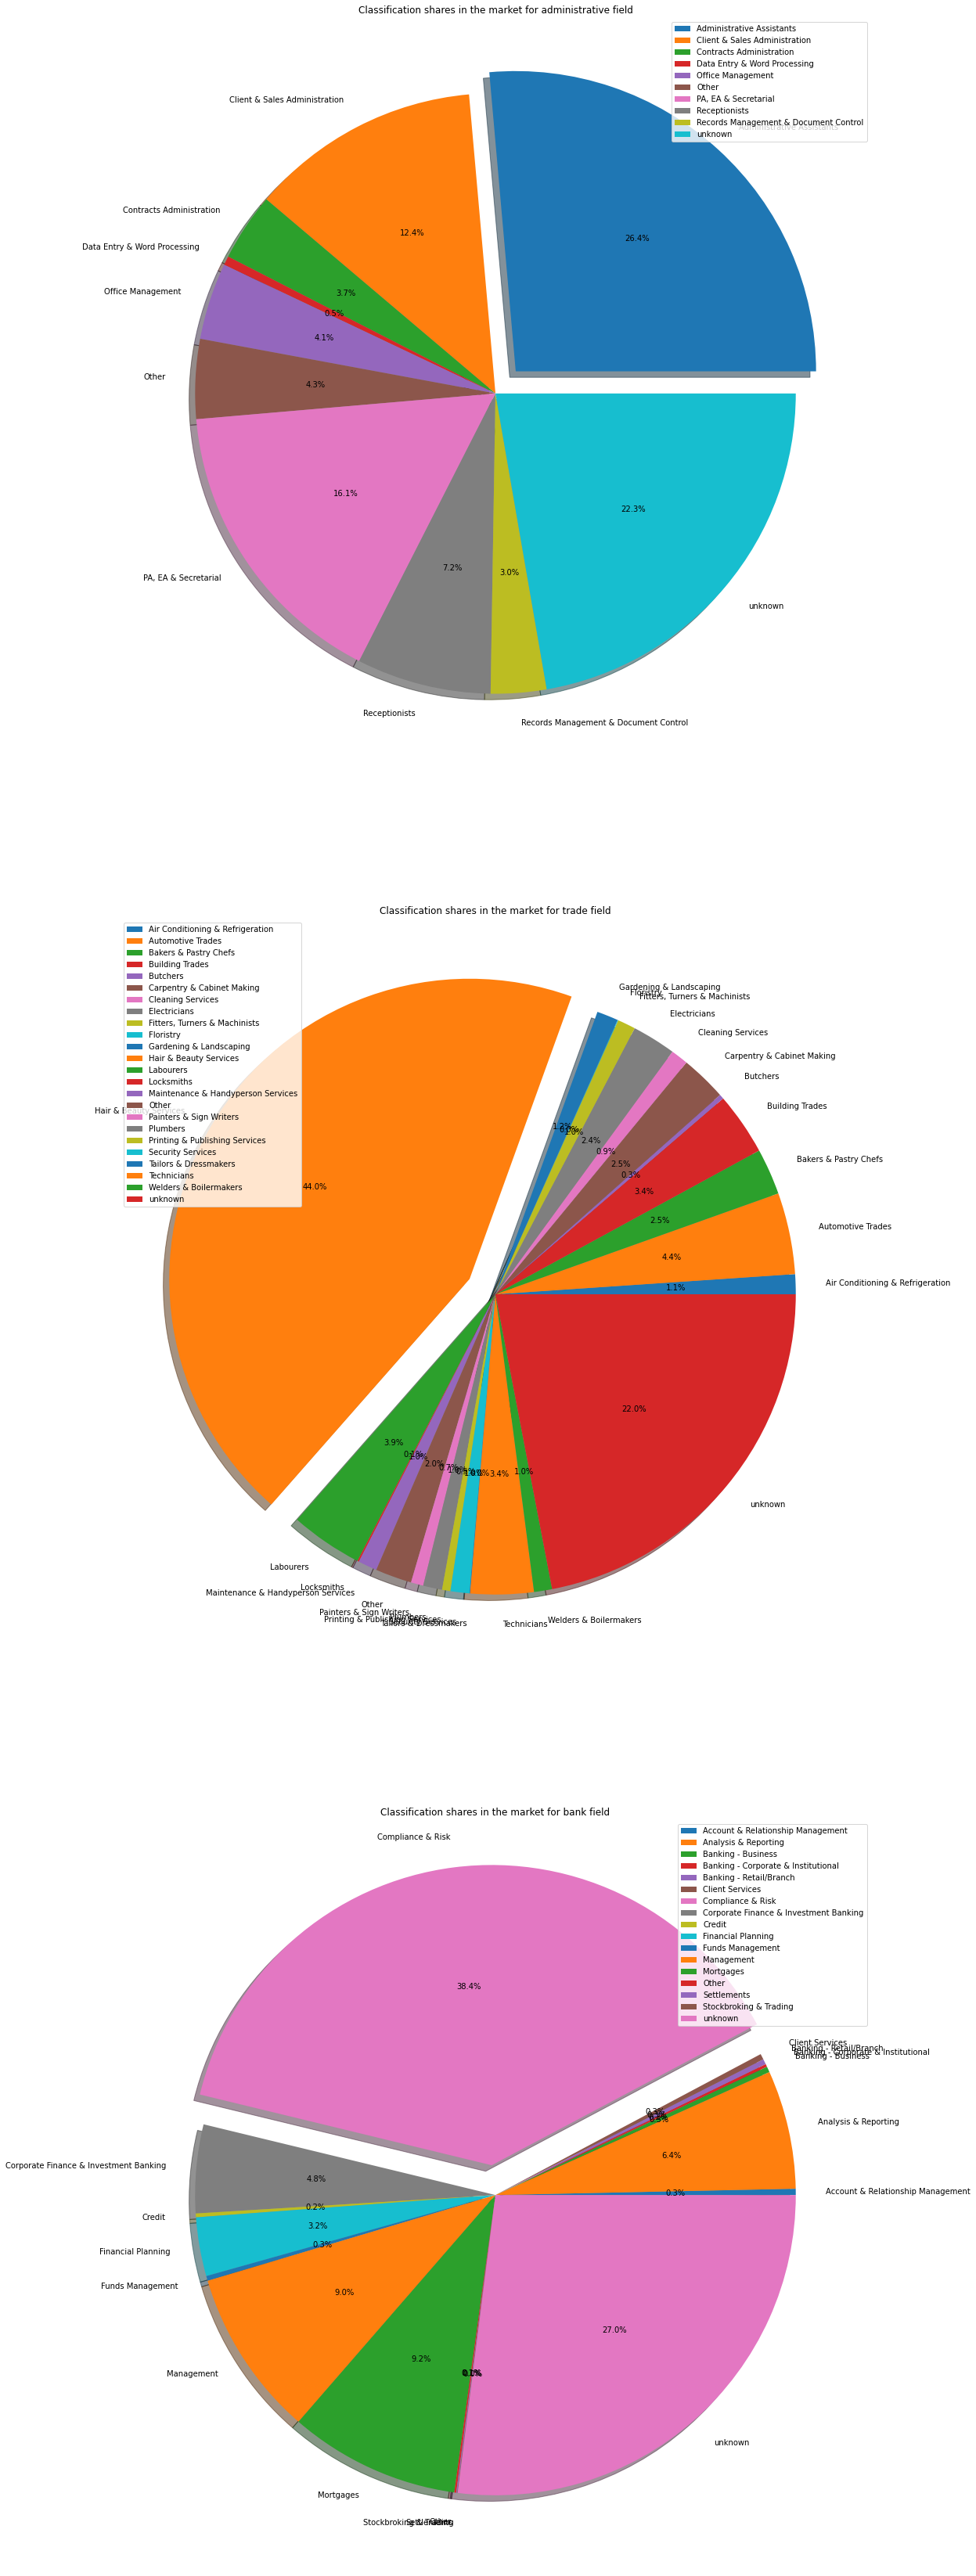

In [123]:
# classification shares in the market.

# administrative field classification shares in the market 

# Make figure and axes
fig, axs = plt.subplots(3, 1,figsize = (30,60),squeeze=False)

#create classi_admin_df which group by classsification column,then sum the count that named count1 based on the classification column.Finally,reset_index.
admin_df['count1'] = 1
# the data frame named classi_df contain 'classification' and 'count1'
classi_admin_df = admin_df[['count1','classification']].groupby(admin_df['classification']).sum().reset_index()
labels_classi_admin = classi_admin_df['classification']
explode_admin = (0.1, 0, 0, 0,0,0,0,0,0,0)

# matplotlib
# draw the pie chart
axs[0][0].pie(classi_admin_df['count1'], labels = labels_classi_admin, autopct='%1.1f%%',shadow  = True,explode = explode_admin)
axs[0][0].set_title('Classification shares in the market for administrative field')
axs[0][0].legend()


# trade field classification shares in the market 
trade_df['count2'] = 1
#create classi_trade_df which group by classsification column,then sum the count that named count2 based on the classification column.Finally,reset_index.
classi_trade_df = trade_df[['count2','classification']].groupby(trade_df['classification']).sum().reset_index()
labels_classi_trade = classi_trade_df['classification']
explode_trade = (0, 0, 0, 0,0,0,0,0,0,0,
                 0,0.1,0, 0, 0,0,0,0,0,0
                 ,0,0,0,0)
# matplotlib
#draw the pie chart
axs[1][0].pie(classi_trade_df['count2'], labels = labels_classi_trade, autopct='%1.1f%%', shadow  = True,explode = explode_trade)
axs[1][0].set_title('Classification shares in the market for trade field')
axs[1][0].legend()


# bank field classification shares in the market 
bank_df['count3'] = 1
#create classi_bank_df which group by classsification column,then sum the count that named count3 based on the classification column.Finally,reset_index.
classi_bank_df = bank_df[['count3','classification']].groupby(bank_df['classification']).sum().reset_index()
labels_classi_bank= classi_bank_df['classification']
explode_bank = (0, 0, 0, 0,0,0,0.1,0,0,0,
                 0,0,0, 0, 0,0,0)


# matplotlib
#draw the pie chart
axs[2][0].pie(classi_bank_df['count3'], labels = labels_classi_bank, autopct='%1.1f%%', shadow  = True,explode = explode_bank)
axs[2][0].set_title('Classification shares in the market for bank field')
axs[2][0].legend()


plt.show()






# Q: show the top 5 hottest job in different field.

## Answers: 
Firstly, we create 1 row x 3 columns axes with no data and modify the figure size, then we create new dataframe for administrative, trade and bank field. These dataframes are each grouped by role and count it based on the role.Then,reset index. We can see the first 5 row in these different field dataframes. Then, we draw the bar chart for each field by using matplotlib method. Finally ,set them label.

From the bar chart, we can see that, Executive Assistant, Temporary Office Roles, Contracts Administrator, Team Administrator, and Temp Receptionists are the top 5 hottest job in the administrative field.

In the trade field, we can see that, Hair Stylist, Beauty Therapist, Senior Stylist, Senior Stylist - part time, Barber/ Senior Barber are the top 5 hottest job in the trade field.

In the bank field, we can see that, Mortgage Broker, Regulatory and Compliance Manager -12 month contract, Head of Technology & Digital Risk, Risk Manager, and Online Broker are the top 5 hottest job in the bank field.




/Users/wangzhuoxin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/Users/wangzhuoxin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/wangzhuoxin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator


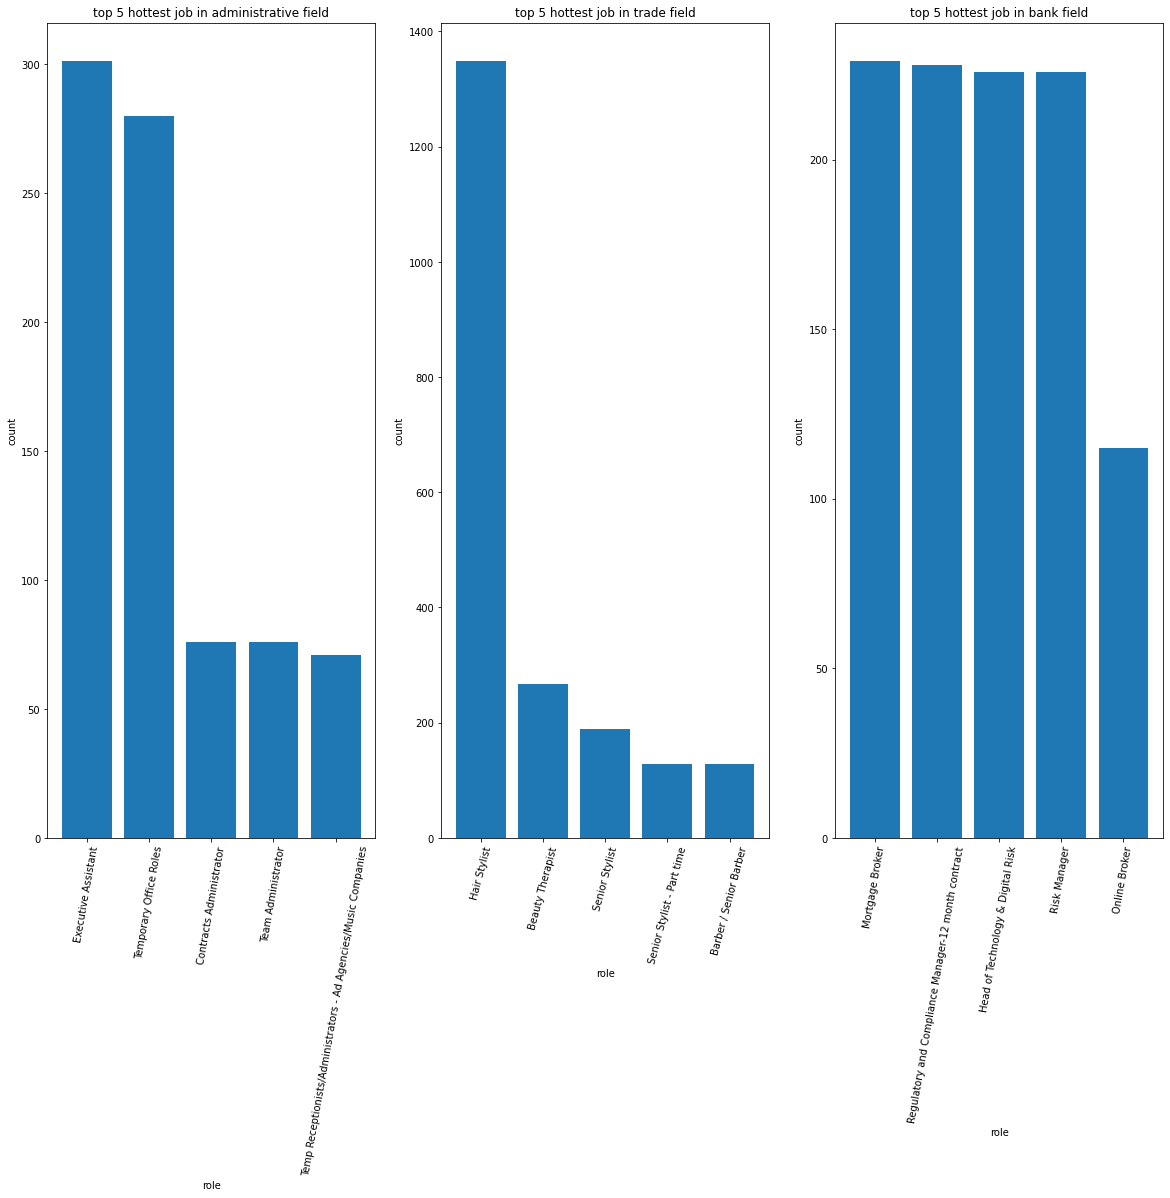

In [82]:
fig, axs = plt.subplots(1,3 ,squeeze=False, figsize = (20,15))

# top5 hottest job in the administrative field

#create job_title_admin which group by role(admin_df[0])then sum the count based on the role.Finally,reset_index.
job_title_admin = admin_df[[0,'count']].groupby(admin_df[0]).sum().reset_index()
#Then sort values by using count column,by using a decending order. Just appear frist 5 row.
job_title_admin = job_title_admin.sort_values(by=['count'],ascending=False).head(5)

# set x label's that is role, modify rotation 
axs[0][0].set_xticklabels(job_title_admin[0],rotation = 80)
# draw the bar chart
axs[0][0].bar(job_title_admin[0],job_title_admin['count'])
# set xlabel, ylabel, and title
axs[0][0].set_xlabel('role')
axs[0][0].set_ylabel('count')
axs[0][0].set_title('top 5 hottest job in administrative field')


# top5 hottest job in the trade field

#create job_title_trade which group by role(admin_df[0])then sum the count based on the role.Finally,reset_index.
job_title_trade = trade_df[[0,'count']].groupby(trade_df[0]).sum().reset_index()
#Then sort values by using count column,by using a decending order. Just appear frist 5 row.
job_title_trade = job_title_trade.sort_values(by=['count'],ascending=False).head(5)


# set x label's that is role, modify rotation 
axs[0][1].set_xticklabels(job_title_trade[0],rotation = 75)
# draw the bar chart
axs[0][1].bar(job_title_trade[0],job_title_trade['count'])
# set xlabel, ylabel, and title
axs[0][1].set_xlabel('role')
axs[0][1].set_ylabel('count')
axs[0][1].set_title('top 5 hottest job in trade field')



# top5 hottest job in the bank field

#create job_title_bank which group by role(admin_df[0])then sum the count based on the role.Finally,reset_index.
job_title_bank = bank_df[[0,'count']].groupby(bank_df[0],).sum().reset_index()
#Then sort values by using count column,by using a decending order. Just appear frist 5 row.
job_title_bank = job_title_bank.sort_values(by=['count'],ascending=False).head(5)



# set x label's that is role, modify rotation 
axs[0][2].set_xticklabels(job_title_bank[0],rotation = 80)
# draw the bar chart
axs[0][2].bar(job_title_bank[0],job_title_bank['count'])
# set xlabel, ylabel, and title
axs[0][2].set_xlabel('role')
axs[0][2].set_ylabel('count')
axs[0][2].set_title('top 5 hottest job in bank field')





plt.show()



# Q: Show mean salary distribution for different field

## Answers: 
Firstly, we create 3 row x 1 columns axes with no data and modify the figure size, then we create each new dataframe in administrative, trade and bank field. These dataframes are each group by location column and calculate the mean of high salary and low salary based on the location column. Then,reset index. Fianlly, we draw the multiple bar chart for each field by using matplotlib method. Finally ,set them label for each field.  

We can see from the multiple bar chart in the administrative field,there is no difference between low salary and high salary in the location of Rest of Tasman, Rest of West Coast and Wanganui. Therefore, there is not much gap between rich and poor. However, these is large difference between low salary and high salary in the location of Taupo and Waitakere & West Auckland. Therefore, there is huge gap between rich and poor.

In the trade field, we can see there is no difference between low salary and high salary in the location of Rest of Taranaki, Rest of Tasman, Rest of West Coast, Taupo, and Wanganui. Therefore, there is no much gap between rich and poor.
However,there is huge difference that is $20000 higher between low salary and high salary in the location of New Plymouth and Rest of Bay of Plenty.


In the bank field, we can see there is no difference between low salary and high salary in the location of Gisborne, New Plymouth, Queenstown & Wanaka, Rest of Taranaki, Timaru & South Canterbury,Whangarei. Therefore, there is no much gap between rich and poor.However,there is huge difference between low salary and high salary in the location of Hamilton.



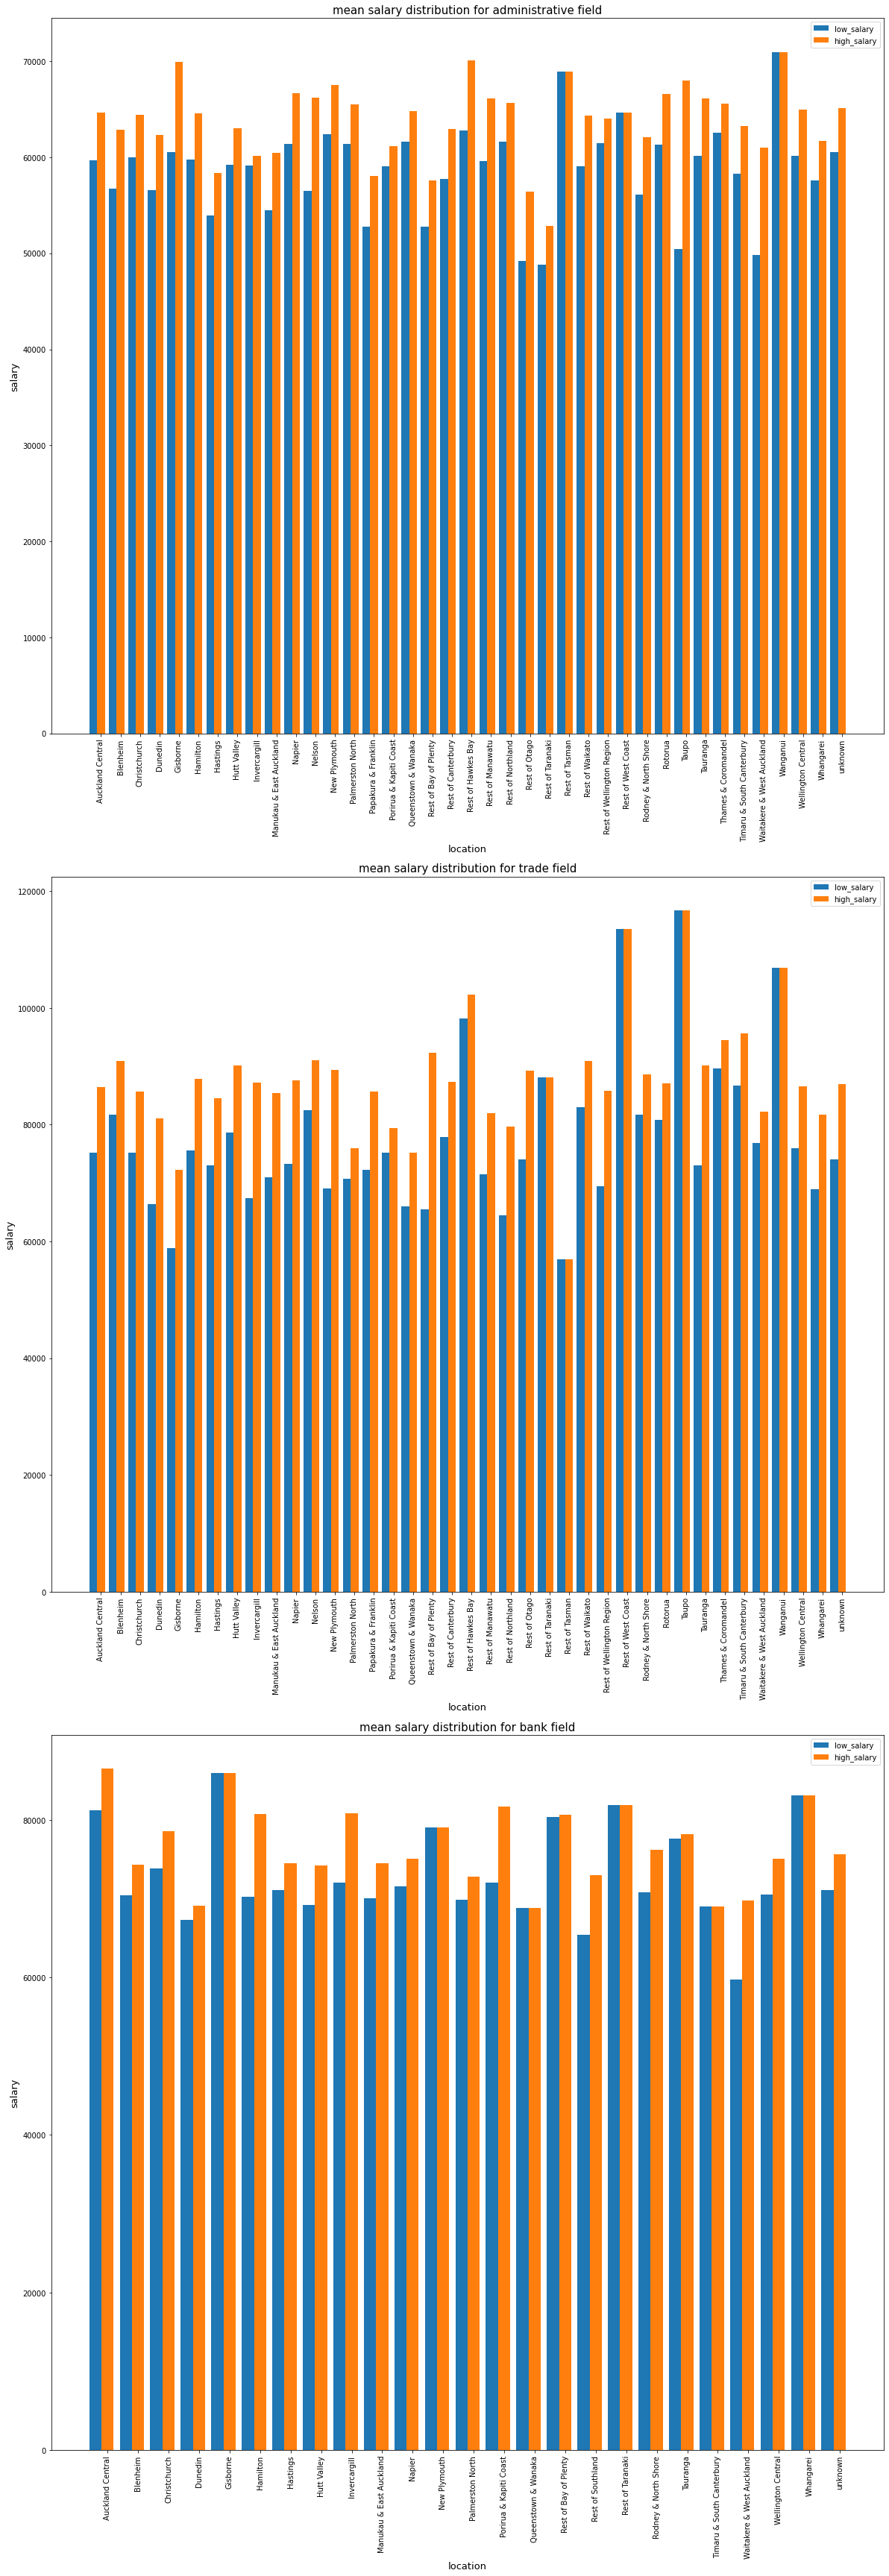

In [39]:
#set width of bar and create 3 row x 1 columns axes
barWidth =0.4
fig, axs = plt.subplots( 3,1, squeeze = False,figsize = (20,60))


# mean salary distribution for administrative field
#create admin_df2 which group by location column then calculate mean of low_salary and high_salary based on the location column.Finally,reset_index.
admin_df2 = admin_df[['low_salary', 'high_salary']].groupby(admin_df['location']).mean().reset_index()


## Set position of bar on X axis
br1 = [i-0.4for i in range(len(admin_df2.index))]
br2 = [x + 0.4 for x in br1]

# Make the plot
rect1 = axs[0][0].bar(br1,admin_df2['low_salary'],width=barWidth, label ='low_salary')
rect2 = axs[0][0].bar(br2, admin_df2['high_salary'],width=barWidth,  label ='high_salary')


# Adding Xticks
axs[0][0].set_xlabel('location', fontsize = 13)
axs[0][0].set_ylabel('salary', fontsize = 13)
axs[0][0].set_title('mean salary distribution for administrative field',fontsize = 15)
axs[0][0].set_xticks([r + 0.001 for r in range(len(admin_df2.index))])
axs[0][0].set_xticklabels(admin_df2['location'],rotation = 90)
axs[0][0].legend()




# mean salary distribution for trade field
#create trade_df2 which group by location column then calculate mean of low_salary and high_salary based on the location column.Finally,reset_index.
trade_df2 = trade_df[['low_salary', 'high_salary']].groupby(admin_df['location']).mean().reset_index()
br3 = [i-0.4for i in range(len(trade_df2.index))]
br4 = [x + 0.4 for x in br3]

# Make the plot
rect3 = axs[1][0].bar(br3,trade_df2['low_salary'],width=barWidth, label ='low_salary')
rect4 = axs[1][0].bar(br4, trade_df2['high_salary'],width=barWidth,  label ='high_salary')


# Adding Xticks
axs[1][0].set_xlabel('location', fontsize = 13)
axs[1][0].set_ylabel('salary', fontsize = 13)
axs[1][0].set_title('mean salary distribution for trade field', fontsize = 15)
axs[1][0].set_xticks([r + 0.001 for r in range(len(trade_df2.index))])
axs[1][0].set_xticklabels(trade_df2['location'],rotation = 90)
axs[1][0].legend()


# mean salary distribution for bank field
#create bank_df2 which group by location column then calculate mean of low_salary and high_salary based on the location column.Finally,reset_index.
bank_df2 = bank_df[['low_salary', 'high_salary']].groupby(bank_df['location']).mean().reset_index()
br5 = [i-0.4for i in range(len(bank_df2.index))]
br6 = [x + 0.4 for x in br5]

# Make the plot
rect5 = axs[2][0].bar(br5,bank_df2['low_salary'],width=barWidth, label ='low_salary')
rect6 = axs[2][0].bar(br6, bank_df2['high_salary'],width=barWidth,  label ='high_salary')


# Adding Xticks
axs[2][0].set_xlabel('location', fontsize = 13)
axs[2][0].set_ylabel('salary', fontsize = 13)
axs[2][0].set_title('mean salary distribution for bank field', fontsize = 15)
axs[2][0].set_xticks([r + 0.001 for r in range(len(bank_df2.index))])
axs[2][0].set_xticklabels(bank_df2['location'],rotation = 90)
axs[2][0].legend()






plt.show()






# Q: Which post day has the difference between low and high salary is the larger than others and which post day has no changes beween low salary and high salary? 

## Answers: 
Firstly, we create 3 row x 1 columns axes with no data and modify the figure size, then we change the type of post time, high salary and low salary for each dataframe in administrative, trade and bank field. Then, we create dataframe for each field, these dataframes are each group by post time column and calculate the mean of high salary and low salary based on the post time column. Then,reset index. And also sort values by post time that using descending order. Fianlly, we draw the line plot for each field by using seaborn method. Finally ,modify the label and set text for each field.  

We can see from the line plot, the high salary and low salary has a similar trend in the graph in each different field. With post day increased by, when high salary goes up, the low salary also have positive relationship between salary and post day.

Therefore, the administrative field, we can see from the line plot, the post day that 8 days ago that has the huge difference between low salary and high salary. The post day that 270 days ago and 330 days ago has no changes between high salary and low salary.

In the trade field, we can see from the line plot, the post day that 24 days ago that has huge difference between low salary and high salary. The post day that 180 days ago, 570 days ago, 720 days ago, 1470 days ago, 1500 days ago and 1710 days ago has no changes between low salary and high salary.

In the bank field, we can see from the line plot, the post day that 1 day ago that has huge differnece between low salary and high salary. The post day that 2 days ago, 9 days ago, 420 days ago, 1020 days ago has no changes between low salary and high salary.



Text(0, 0.5, 'mean of salary')

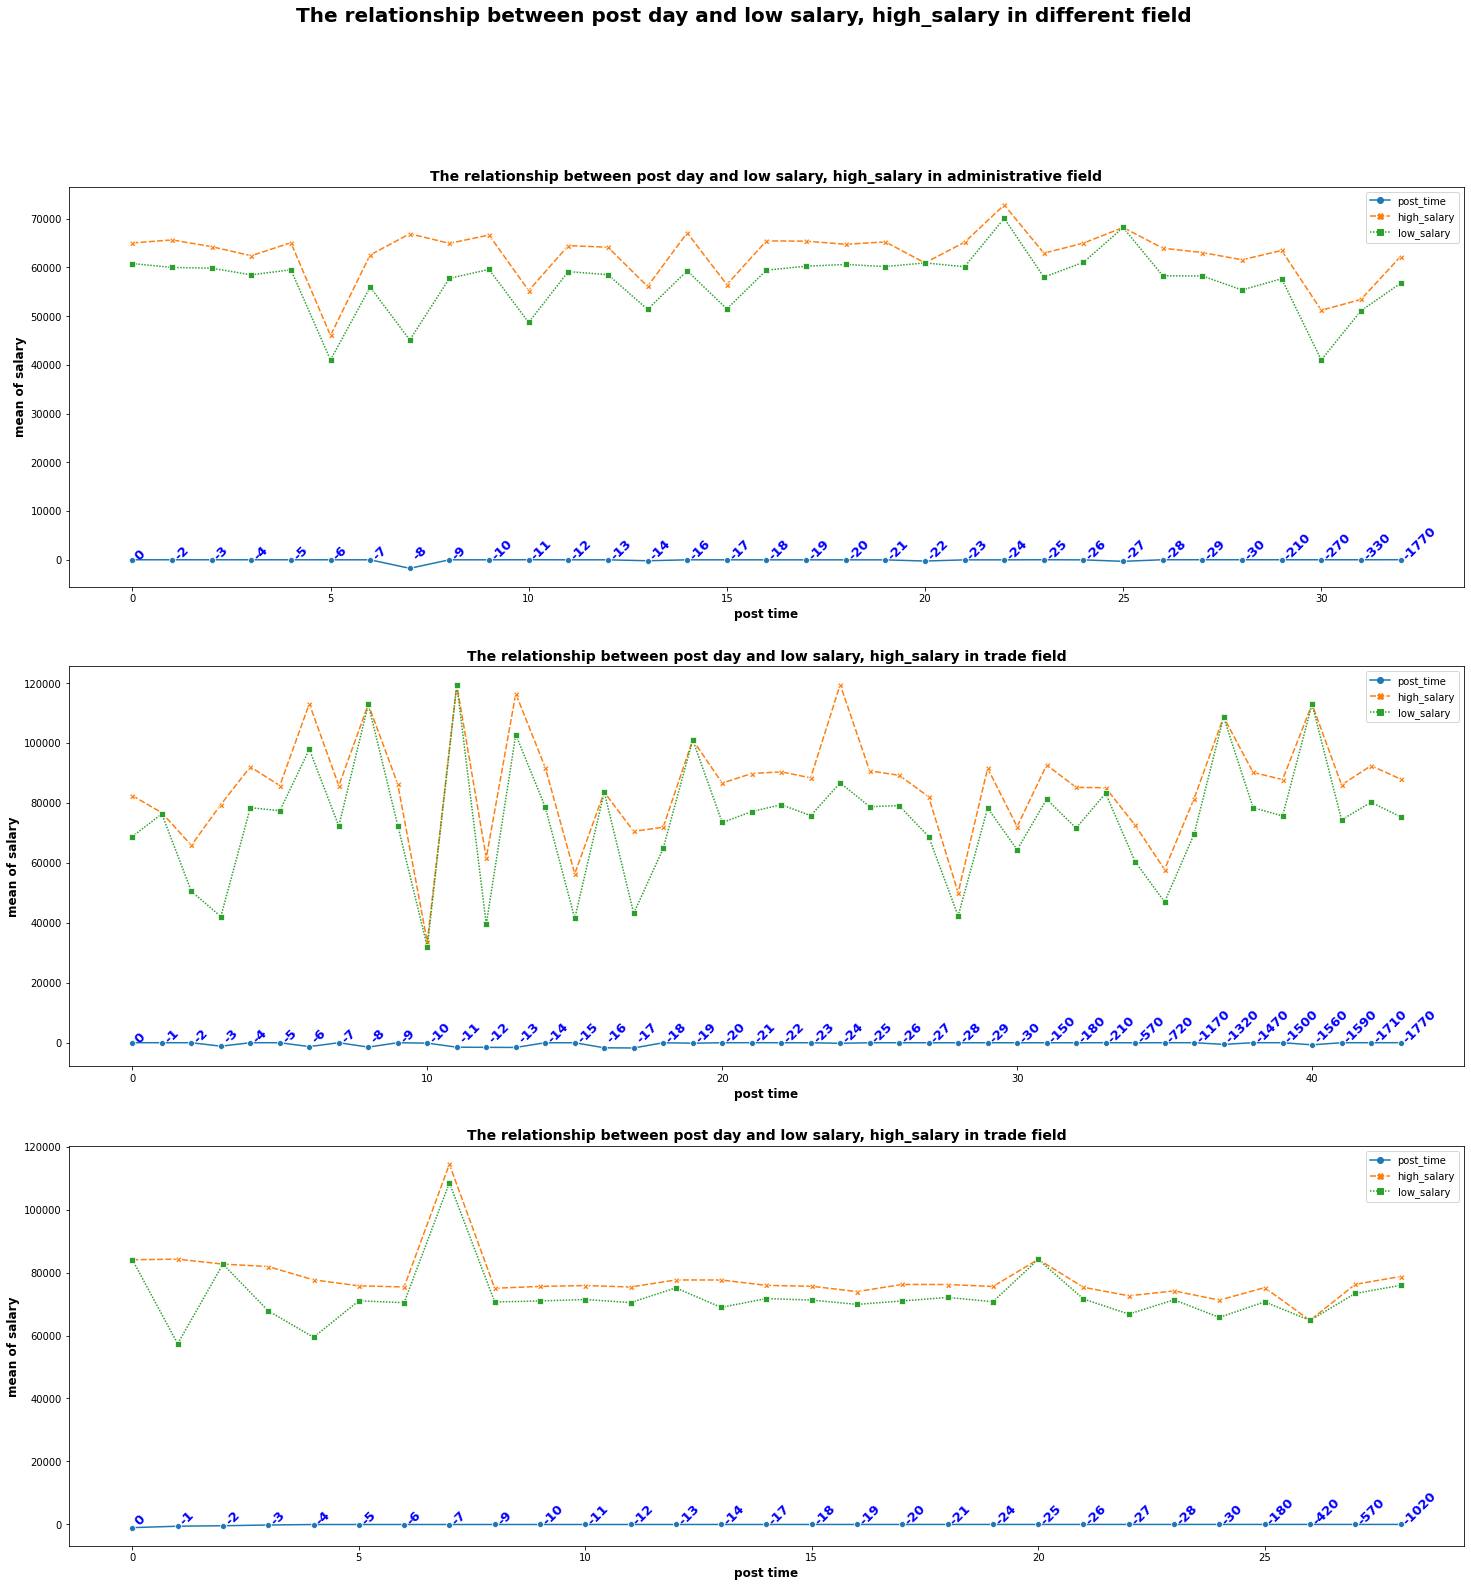

In [124]:
#seaborn

fig, axes = plt.subplots(3,1,figsize = (25,25))
fig.suptitle('The relationship between post day and low salary, high_salary in different field',fontweight='bold',fontsize = 20)


# salary change from time to time in administrative field
admin_df['post_time'] = admin_df['post_time'].astype('str')
admin_df['high_salary'] = admin_df['high_salary'].astype('float32')
admin_df['low_salary'] = admin_df['low_salary'].astype('float32')



# First, groupby post_time, then calculate mean of high_salary and low_salary's mean based on post_time.Then, reset_index.
salary_line = admin_df[['post_time','high_salary','low_salary']].groupby('post_time').mean()
salary_line = salary_line.reset_index()
salary_line['post_time'] = salary_line['post_time'].astype('int')
#Finally sort values by using post_time column, descending order
salary_line = salary_line.sort_values(by = ['post_time'],ascending = False)

# create number text on the xlabel.
for i, v in enumerate(salary_line['post_time'] ):
    axes[0].text(i, i , str(v), color='blue', fontweight='bold',fontsize = 13,rotation =45)

# draw the line plot
sns.lineplot(markers = True,data=salary_line,ax = axes[0])

# set labels
axes[0].set_title('The relationship between post day and low salary, high_salary in administrative field',fontweight='bold',fontsize = 14)
axes[0].set_xlabel('post time',fontweight='bold',fontsize = 12)
axes[0].set_ylabel('mean of salary',fontweight='bold',fontsize = 12)



# salary change from time to time in trade field
trade_df['post_time'] = trade_df['post_time'].astype('str')
trade_df['high_salary'] = trade_df['high_salary'].astype('float32')
trade_df['low_salary'] = trade_df['low_salary'].astype('float32')



# First, groupby post_time, then calculate mean of high_salary and low_salary's mean based on post_time.Then, reset_index.
salary_line2 = trade_df[['post_time','high_salary','low_salary']].groupby('post_time').mean()
salary_line2 = salary_line2.reset_index()
salary_line2['post_time'] = salary_line2['post_time'].astype('int')

#Finally sort values by using post_time column, descending order
salary_line2 = salary_line2.sort_values(by = ['post_time'],ascending = False)

# create number text on the xlabel.
for i, v in enumerate(salary_line2['post_time'] ):
    axes[1].text(i, i , str(v), color='blue', fontweight='bold',fontsize = 13,rotation =45)
    
# draw the line plot by using seaborn method
sns.lineplot(markers = True,data=salary_line2,ax = axes[1])

# set_labels
axes[1].set_title('The relationship between post day and low salary, high_salary in trade field',fontweight='bold',fontsize = 14)
axes[1].set_xlabel('post time',fontweight='bold',fontsize = 12)
axes[1].set_ylabel('mean of salary',fontweight='bold',fontsize = 12)



# salary change from time to time in bank field
# First, groupby post_time, then calculate mean of high_salary and low_salary's mean based on post_time.Then, reset_index.
salary_line3 = bank_df[['post_time','high_salary','low_salary']].groupby('post_time').mean()
salary_line3 = salary_line3.reset_index()
salary_line3['post_time'] = salary_line3['post_time'].astype('int')

#Finally sort values by using post_time column, descending order
salary_line3 = salary_line3.sort_values(by = ['post_time'],ascending = False)

# create number text on the xlabel.
for i, v in enumerate(salary_line3['post_time'] ):
    axes[2].text(i, i , str(v), color='blue', fontweight='bold',fontsize = 13,rotation =45)
    
# draw the line plot by using seaborn method
sns.lineplot(markers = True,data=salary_line3,ax = axes[2])

#set_labels
axes[2].set_title('The relationship between post day and low salary, high_salary in trade field',fontweight='bold',fontsize = 14)
axes[2].set_xlabel('post time',fontweight='bold',fontsize = 12)
axes[2].set_ylabel('mean of salary',fontweight='bold',fontsize = 12)

